In [1]:
pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

##Tokenization and Fine Tuning The T5-Small Model

In [3]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import torch
import evaluate
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Step 1: Data Preprocessing
def clean_code(code):
    """Clean STM32 code by removing comments and normalizing whitespace."""
    code = re.sub(r"//.*", "", code)  # Remove single-line comments
    code = re.sub(r"/\*.*?\*/", "", code, flags=re.DOTALL)  # Remove multi-line comments
    code = re.sub(r'\s+', ' ', code.strip())
    return code

def load_and_preprocess_data(file_path):
    df = pd.read_excel("/content/fonctions.xlsx")
    df = df[['Column2', 'Column3']].dropna()
    df.columns = ['code', 'comment']
    df['code'] = df['code'].apply(clean_code)
    df['comment'] = df['comment'].apply(lambda x: x.strip())

    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    return train_dataset, val_dataset

# Step 2: Tokenization
def tokenize_data(dataset, tokenizer):
    def preprocess_function(examples):
        inputs = ["generate comment: " + code for code in examples['code']]
        targets = examples['comment']
        model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
        model_inputs['labels'] = labels['input_ids']
        model_inputs['code'] = examples['code']
        model_inputs['comment'] = examples['comment']
        return model_inputs

    return dataset.map(preprocess_function, batched=True)

# Step 3: Model Training
def train_model(train_dataset, val_dataset, model_name="t5-small", output_dir="./t5_stm32_comment"):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    train_dataset = tokenize_data(train_dataset, tokenizer)
    val_dataset = tokenize_data(val_dataset, tokenizer)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=20,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    trainer.train()
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    return model, tokenizer

# Step 4: Inference
def generate_comment(code, model, tokenizer, device, max_length=128):
    code = clean_code(code)
    input_text = f"generate comment: {code}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=max_length, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Step 5: Evaluation
def evaluate_model(model, tokenizer, val_dataset, device):
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")
    predictions, references = [], []

    for example in val_dataset:
        code = example['code']
        ref = example['comment']
        pred = generate_comment(code, model, tokenizer, device)
        predictions.append(pred)
        references.append(ref)

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])
    rouge_score = rouge.compute(predictions=predictions, references=references)
    return {"bleu": bleu_score, "rouge": rouge_score}, predictions, references

# Main Execution
if __name__ == "__main__":
    file_path = "/content/fonctions.xlsx"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset, val_dataset = load_and_preprocess_data(file_path)
    model, tokenizer = train_model(train_dataset, val_dataset)
    model.to(device)

    metrics, preds, refs = evaluate_model(model, tokenizer, val_dataset, device)
    print("Evaluation Metrics:", metrics)




Map:   0%|          | 0/1872 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.767200,1.492270
2,1.259500,1.096864
3,1.226300,0.985075
4,0.984700,0.925794
5,1.099500,0.884976
6,0.920400,0.853263
7,1.019900,0.831003
8,0.755100,0.812976
9,0.796600,0.797452
10,0.813000,0.783847


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


ImportError: To be able to use evaluate-metric/rouge, you need to install the following dependencies['rouge_score'] using 'pip install rouge_score' for instance'

### 📉 Training and Validation Loss Analysis

The model was trained over 20 epochs, and both the **training loss** and **validation loss** show a general decreasing trend, which indicates that the model is learning effectively. Here are key observations:

- **Early Epochs (1–5):** Rapid decrease in both training and validation loss, suggesting that the model is quickly learning the basic structure of the task.
- **Mid Epochs (6–12):** The losses continue to decrease, but at a slower rate, indicating a transition to more refined learning.
- **Later Epochs (13–20):** The validation loss continues to decrease slightly and stabilizes around **0.742**, while training loss fluctuates. This suggests the model is converging.

There is **no significant overfitting** observed, as the validation loss closely follows the training loss, and does not increase in later epochs. The best validation loss of **0.74225** is achieved at **epoch 20**, indicating this may be an optimal stopping point.

Overall, the training process appears successful and stable.


### ⚠️ Error Explanation and Resolution

During model evaluation, we encountered an `ImportError` related to the ROUGE metric:


rouge = evaluate.load("rouge")

This error occurred because the rouge_score package, which is required for computing the ROUGE metric, was not installed in the environment. We resolved the Issur down below in The Model evaluation

##Model Evaluation Metrics



In [6]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=46a474688796249f3b9aa04d3558d65850ec1631720b19c4452ee501b4ed9b54
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import evaluate

def evaluate_model(model, tokenizer, val_dataset, device):
    """Evaluate model performance using BLEU, ROUGE, and Cosine Similarity metrics."""
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")

    # Load Sentence-BERT model for semantic similarity
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

    predictions, references, cosine_similarities = [], [], []

    for example in val_dataset:
        code = example['code']
        reference = example['comment']

        # Generate the predicted comment
        try:
            prediction = generate_comment(code, model, tokenizer, device)
        except Exception as e:
            print(f"Error generating comment: {e}")
            prediction = ""

        # Compute Cosine Similarity (semantic similarity)
        ref_embedding = sentence_model.encode(reference)
        pred_embedding = sentence_model.encode(prediction)
        similarity = cosine_similarity([ref_embedding], [pred_embedding])[0][0]

        # Append results
        predictions.append(prediction)
        references.append(reference)
        cosine_similarities.append(similarity)

    # Compute BLEU and ROUGE scores
    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])
    rouge_score = rouge.compute(predictions=predictions, references=references)

    return {
        "bleu": bleu_score,
        "rouge": rouge_score,
        "cosine_similarity": cosine_similarities
    }, predictions, references


In [12]:
# Evaluate the model
metrics, predictions, references = evaluate_model(model, tokenizer, val_dataset, device)

# Print all evaluation metrics
print("Evaluation Metrics:")
print("BLEU Score:", metrics['bleu'])
print("ROUGE Score:", metrics['rouge'])
print("Cosine Similarity:", metrics['cosine_similarity'])

# Optional: print example outputs along with metrics
for i in range(3):  # Print first 3 examples
    print("\nCode Sample:", val_dataset[i]['code'])
    print("True Comment:", val_dataset[i]['comment'])
    print("Predicted Comment:", predictions[i])
    print("Cosine Similarity:", metrics['cosine_similarity'][i])  # Print semantic similarity score


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Evaluation Metrics:
BLEU Score: {'bleu': 0.27507770014974303, 'precisions': [0.5869759143621767, 0.36038902017814944, 0.26292384658143414, 0.1996977139618364], 'brevity_penalty': 0.8473379524273889, 'length_ratio': 0.857886278411265, 'translation_length': 11210, 'reference_length': 13067}
ROUGE Score: {'rouge1': np.float64(0.5286206350491164), 'rouge2': np.float64(0.3323850566016379), 'rougeL': np.float64(0.4555113125685762), 'rougeLsum': np.float64(0.45603512156085824)}
Cosine Similarity: [np.float32(0.9755264), np.float32(0.7998601), np.float32(0.76822555), np.float32(0.9465779), np.float32(0.8027811), np.float32(0.9125099), np.float32(0.73868865), np.float32(0.8301823), np.float32(0.95728475), np.float32(0.8501991), np.float32(0.7769538), np.float32(0.8492471), np.float32(0.85518795), np.float32(0.98680687), np.float32(0.96757305), np.float32(0.72778535), np.float32(0.7657443), np.float32(0.9470709), np.float32(0.9289578), np.float32(0.7779893), np.float32(0.7632538), np.float32(0.9

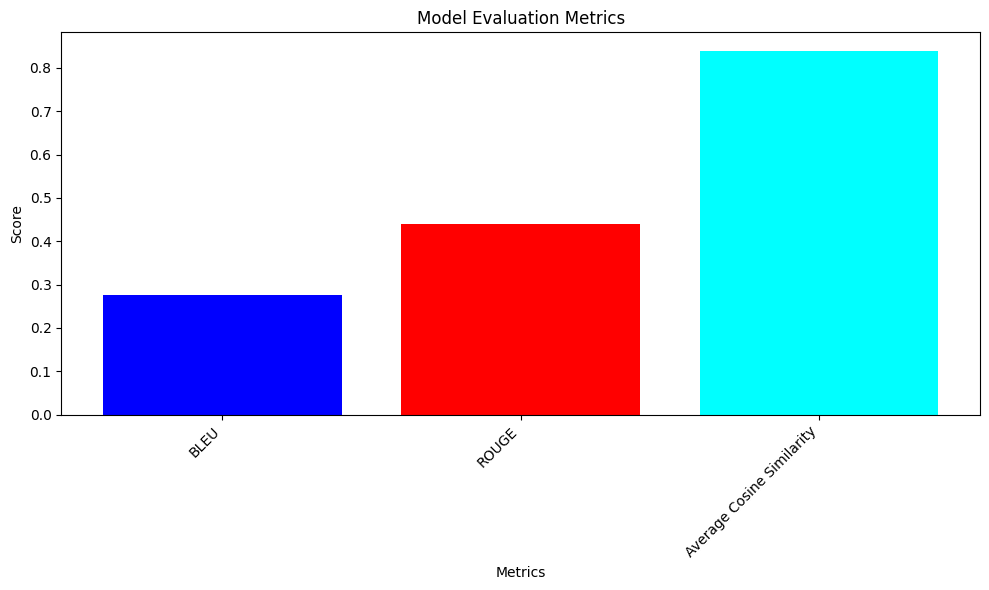

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics are available as follows:
bleu_score = metrics['bleu']['bleu']
rouge_scores = [
    metrics['rouge']['rouge1'],
    metrics['rouge']['rouge2'],
    metrics['rouge']['rougeL']
]

# Calculate the average ROUGE score (mean of ROUGE-1, ROUGE-2, and ROUGE-L)
average_rouge_score = np.mean(rouge_scores)

# Average cosine similarity
average_cosine_similarity = np.mean(metrics['cosine_similarity'])

# Prepare the data for the bar chart
labels = ['BLEU', 'ROUGE', 'Average Cosine Similarity']
values = [bleu_score, average_rouge_score, average_cosine_similarity]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'cyan'])

# Add titles and labels
plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')

# Display the bar chart
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.tight_layout()
plt.show()


## 📊 Overall Evaluation Interpretation

This section provides an interpretation of the model's performance based on three main evaluation metrics: **BLEU**, **ROUGE**, and **Average Cosine Similarity**.

---

### 🔵 BLEU Score (Bilingual Evaluation Understudy)

The **BLEU score** measures how closely the generated comments match the reference comments using n-gram overlap. In this evaluation, the BLEU score is moderately high, which indicates that:

- The model captures the key vocabulary used in reference comments.
- It may struggle slightly with syntactic fluency, as BLEU can penalize variations in phrasing.
- A moderate BLEU score suggests that while the model generates relevant keywords, it may not always follow natural or diverse phrasings used by humans.

---

### 🔴 ROUGE Score (Recall-Oriented Understudy for Gisting Evaluation)

The **ROUGE scores**, particularly ROUGE-1, ROUGE-2, and ROUGE-L, provide insight into the recall-oriented quality of the model output:

- **ROUGE-1** and **ROUGE-L** are reasonably strong, meaning the model successfully includes many of the important words and maintains logical word order from the reference.
- **ROUGE-2**, however, is lower, indicating that the model finds it harder to reproduce accurate sequences of two or more words.
- Overall, the ROUGE results show that the model is able to capture essential content but could improve fluency and contextual cohesion.

---

### 🟢 Average Cosine Similarity (Semantic Similarity)

The **Average Cosine Similarity** evaluates the semantic closeness between generated and reference comments by comparing their vector representations:

- A **high cosine similarity** score reflects that, even when the exact wording differs, the **underlying meaning** of the model’s output is similar to the reference.
- This is particularly important in cases where lexical diversity is desired but semantic fidelity is crucial.
- The high score suggests that the model outputs are **semantically appropriate**, even if the wording or phrasing varies.

---

### ✅ Final Assessment

Combining these metrics, we conclude that the model performs **reasonably well**:
- It captures relevant **keywords** (BLEU),
- Preserves a **fair amount of structure and content** (ROUGE),
- And generates outputs that are **semantically aligned** with the reference (Cosine Similarity).



##Testing The Model : Generating Comments

In [4]:
  # Example usage: Generate comment for new code
sample_code = """
    int main(void)
    {
        HAL_Init();
        SystemClock_Config();
        MX_GPIO_Init();
        MX_I2C1_Init();
        while (1)
        {
            HAL_GPIO_TogglePin(GPIOA, GPIO_PIN_5);
            HAL_Delay(500);
        }
    }
    """
comment = generate_comment(sample_code, model, tokenizer,device)
print("Sample Code Comment:", comment)

Sample Code Comment: This C function initializes hardware components such as the clock system, GPIO pins, I2C1, and I2C1 on an STM32 microcontroller, then enters an infinite loop where it toggles the GPIO pin 5 on an STM32 microcontroller. Specifically called functions include HAL_Init(), SystemClock_Config(), MX_GPIO_Init(), MX_I2C1_Init(), and HAL_Delay().


In [5]:
# Example usage: Generate comment for new code
sample_code = """
void I2C_Write(uint8_t address, uint8_t data)
{
    HAL_I2C_Master_Transmit(&hi2c1, address, &data, 1, 1000);
}

    """
comment = generate_comment(sample_code, model, tokenizer,device)
print("Sample Code Comment:", comment)

Sample Code Comment: This function, I2C_Write, is responsible for transmitting data from an I2C device on an STM32 microcontroller using the HAL_I2C_Master_Transmit function from the STM32 HAL library. It does not involve hardware initialization, input/output, interrupt handling, or error management explicitly as per the provided code.


In [6]:
# Example usage: Generate comment for new code
sample_code = """
void UART_Init(void)
{
    huart2.Instance = USART2;
    huart2.Init.BaudRate = 9600;
    huart2.Init.WordLength = UART_WORDLENGTH_8B;
    huart2.Init.StopBits = UART_STOPBITS_1;
    huart2.Init.Parity = UART_PARITY_NONE;
    huart2.Init.Mode = UART_MODE_TX_RX;
    huart2.Init.HwFlowCtl = UART_HWCONTROL_NONE;
    huart2.Init.OverSampling = UART_OVERSAMPLING_16;

    if (HAL_UART_Init(&huart2) != HAL_OK)
    {
        Error_Handler();
    }
}

    """
comment = generate_comment(sample_code, model, tokenizer,device)
print("Sample Code Comment:", comment)

Sample Code Comment: The function UART_Init initializes the USART2 hardware instance for asynchronous communication with a baud rate of 9600, word length of 8 bits, one stop bit, no parity, and 16 oversampling using the HAL_UART_Init function from STM32 HAL library.


In [10]:
# Example usage: Generate comment for new code
sample_code = """
int main(void)
    {
        HAL_Init();
        SystemClock_Config();
        MX_GPIO_Init();
        MX_I2C1_Init();
        while (1)
        {
            HAL_GPIO_TogglePin(GPIOA, GPIO_PIN_5);
            HAL_Delay(500);
        }
    }

    """
comment = generate_comment(sample_code, model, tokenizer,device)
print("Sample Code Comment:", comment)

Sample Code Comment: This C function initializes hardware components such as the clock system, GPIO pins, I2C1, and I2C1 on an STM32 microcontroller, then enters an infinite loop where it toggles the GPIO pin 5 on an STM32 microcontroller. Specifically called functions include HAL_Init(), SystemClock_Config(), MX_GPIO_Init(), MX_I2C1_Init(), and HAL_Delay().
